In [105]:
using Lux, LuxCore, ForwardDiff, ReverseDiff, Zygote, Enzyme

struct LagrangianNN{M <: LuxCore.AbstractExplicitLayer} <: Lux.AbstractExplicitContainerLayer{(:model,)}
    model::M
    ad
end

function LagrangianNN(model; ad = AutoForwardDiff())
    @assert ad isa AutoForwardDiff || ad isa AutoZygote || ad isa AutoEnzyme
    !(model isa Lux.AbstractExplicitLayer) && (model = Lux.transform(model))
    return LagrangianNN(model, ad)
end

function (lnn::LagrangianNN{ <: LuxCore.AbstractExplicitLayer})(state, p, st)
    model = Lux.StatefulLuxLayer(lnn.model, nothing, st)
    return model(state, p)[1], model.st
end

In [112]:
using LinearAlgebra

function EulerLagrange(lnn::LagrangianNN{ <: LuxCore.AbstractExplicitLayer}, st)
    function (dstate, state, p, t)
        q = state[1, :]
        qdot = state[2, :]
        
        dLdq = ForwardDiff.gradient(q -> first(lnn(vcat(q, qdot), p, st)), q)
        d_dLdqdot_dq = ForwardDiff.jacobian(q -> ForwardDiff.gradient(qdot -> first(lnn(vcat(q, qdot), p, st)), qdot), q)        
        H = ForwardDiff.hessian(qdot -> first(lnn(vcat(q, qdot), p, st)), qdot)
        
        dstate[1, :] = qdot
        dstate[2, :] = H \ (dLdq - d_dLdqdot_dq * qdot)
    end
end

EulerLagrange (generic function with 1 method)

In [107]:
using OrdinaryDiffEq, DiffEqFlux

struct NeuralLagrangianDE{M <: LagrangianNN} <: DiffEqFlux.NeuralDELayer
    model::M
    tspan
    args
    kwargs
end

function NeuralLagrangianDE(model, tspan, args...; ad = AutoForwardDiff(), kwargs...)
    lnn = model isa LagrangianNN ? model : LagrangianNN(model; ad)
    return NeuralLagrangianDE(lnn, tspan, args, kwargs)
end

function (nlde::NeuralLagrangianDE)(state, ps, st)
    prob = OrdinaryDiffEq.ODEProblem(EulerLagrange(nlde.model, st), state, nlde.tspan, ps)
    sensealg = InterpolatingAdjoint(; autojacvec = ZygoteVJP())
    return Array(OrdinaryDiffEq.solve(prob, nlde.args...; sensealg, nlde.kwargs...)), st
end

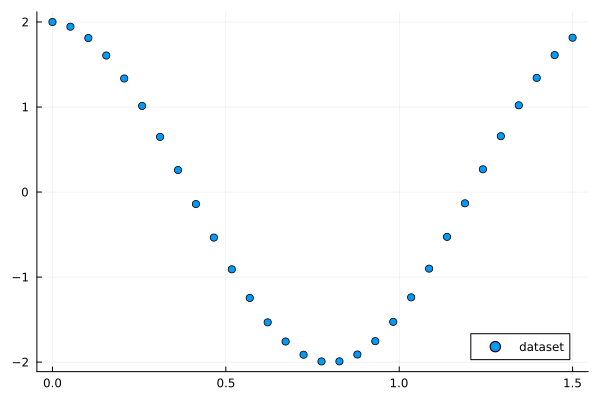

In [113]:
using Plots

function trueODE(du, u, p, t)
    du[1] = u[2]
    du[2] = - 0.5 * 30 * u[1]
end

u0 = Float32[2.0; -0.3]
tspan = (0.0, 1.5)

datasize = 30
tsteps = range(tspan[1], tspan[2]; length = datasize)

true_ode_prob = ODEProblem(trueODE, u0, tspan)
true_sol = Array(solve(true_ode_prob, Tsit5(); saveat = tsteps))

plt = scatter(tsteps, true_sol[1, :], label="dataset")
display(plot(plt))

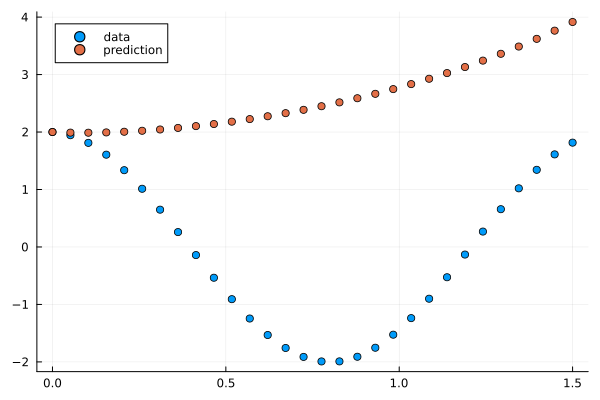

loss 1061.7345


In [115]:
using Random, ComponentArrays, Flux

rng = Random.default_rng()

lnn = LagrangianNN(Flux.Chain(Flux.Dense(2 => 50, tanh), Flux.Dense(50 => 1)); ad = AutoForwardDiff())
ps, st = Lux.setup(rng, lnn)
ps = ps |> ComponentArray
model = NeuralLagrangianDE(lnn, tspan, Tsit5(); saveat = tsteps)

function loss(p)
    pred, _ = model(u0, p, st)
    loss = sum(abs2, true_sol .- pred)
    return loss, pred
end

callback = function (p, l, pred)
    println("loss ", l)
    return false
end

l, pred = loss(ps)
callback(ps, l, pred)
plt = scatter(tsteps, true_sol[1, :]; label = "data")
scatter!(plt, tsteps, pred[1, :]; label = "prediction")
display(plot(plt))


In [117]:
using Optimization, OptimizationOptimisers

adtype = Optimization.AutoForwardDiff()

optf = Optimization.OptimizationFunction((u, p) -> loss(u), adtype)
optprob = Optimization.OptimizationProblem(optf, ps)

result_neuralode = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.1); callback = callback, maxiters = 1)

loss 1061.7345
loss 1061.7345


InterruptException: InterruptException:

In [ ]:
l, pred = loss(result_neuralode.u)
callback(result_neuralode.u, l, pred)
plt = scatter(tsteps, true_sol[1, :]; label = "data")
scatter!(plt, tsteps, pred[1, :]; label = "prediction")
display(plot(plt))